
---

## Objectives
1. Load and explore IRDS dataset structure
2. Understand data format and organization
3. Analyze subject demographics
4. Examine gesture types and labels
5. Assess data quality and completeness 

----

In [2]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
from collections import defaultdict
import re
from tqdm import tqdm

# Add src to path
sys.path.append('../../src')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

np.random.seed(42)

print('Libraries imported successfully!')
print(f'Python version: {sys.version}')
print(f'NumPy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')

Libraries imported successfully!
Python version: 3.8.20 (default, Oct  3 2024, 15:24:27) 
[GCC 11.2.0]
NumPy version: 1.22.3
Pandas version: 1.4.2


In [ ]:

DATA_PATH = Path(".../ path / to / data")
RESULTS_PATH = Path("../../results")
FIGURES_PATH = RESULTS_PATH / "figures" / "eda"


if DATA_PATH.exists():
    print(f"✓ Data path found: {DATA_PATH}")
    txt_files = list(DATA_PATH.glob("*.txt"))
    print(f"✓ Found {len(txt_files)} .txt files")
else:
    print(f"✗ Data path not found: {DATA_PATH}")
    print("Please check the path and update DATA_PATH variable")

✓ Data path found: /home/gaurav/STW7072CEM_IRDS_Classification/data/raw/irds/Simplified
✓ Found 2589 .txt files


In [ ]:
# gesture types and descriptions
GESTURE_MAPPING = {
    0: "Elbow flexion-extension",
    1: "Shoulder flexion-extension", 
    2: "Shoulder abduction-adduction",
    3: "Shoulder internal-external rotation",
    4: "Wrist supination-pronation",
    5: "Wrist flexion-extension",
    6: "Wrist ulnar-radial deviation",
    7: "Hand open-close",
    8: "Reach forward"
}

# Kinect joint names (25 joints)
JOINT_NAMES = [
    'SpineBase', 'SpineMid', 'Neck', 'Head', 'ShoulderLeft',
    'ElbowLeft', 'WristLeft', 'HandLeft', 'ShoulderRight', 'ElbowRight',
    'WristRight', 'HandRight', 'HipLeft', 'KneeLeft', 'AnkleLeft',
    'FootLeft', 'HipRight', 'KneeRight', 'AnkleRight', 'FootRight',
    'SpineShoulder', 'HandTipLeft', 'ThumbLeft', 'HandTipRight', 'ThumbRight'
]

#position mapping for binary classification
POSITION_MAPPING = {
    'stand': 'Standing',
    'stand-frame': 'Standing',
    'chair': 'Sitting',
    'wheelchair': 'Sitting',
    'sit': 'Sitting'
}

print("Gesture types:")
for gesture_id, description in GESTURE_MAPPING.items():
    print(f"  {gesture_id}: {description}")
    
print(f"\nTotal joints: {len(JOINT_NAMES)}")
print(f"Total features per frame: {len(JOINT_NAMES) * 3} (x, y, z coordinates)")

Gesture types:
  0: Elbow flexion-extension
  1: Shoulder flexion-extension
  2: Shoulder abduction-adduction
  3: Shoulder internal-external rotation
  4: Wrist supination-pronation
  5: Wrist flexion-extension
  6: Wrist ulnar-radial deviation
  7: Hand open-close
  8: Reach forward

Total joints: 25
Total features per frame: 75 (x, y, z coordinates)


In [ ]:
# Parse filenames and extract metadata
def parse_filename(filename):
    """
    IRDS filename format: SubjectID_DateID_GestureLabel_RepetitionNo_CorrectLabel_Position.txt
    """
    parts = filename.stem.split('_')
    if len(parts) == 6:
        return {
            'subject_id': int(parts[0]),
            'date_id': int(parts[1]),
            'gesture': int(parts[2]),
            'repetition': int(parts[3]),
            'correct_label': int(parts[4]),
            'position': parts[5],
            'position_binary': POSITION_MAPPING.get(parts[5], 'Unknown'),
            'filename': filename.name
        }
    return None

# Parse all filenames
metadata = []
for file_path in txt_files:
    file_info = parse_filename(file_path)
    if file_info:
        metadata.append(file_info)

# Create DataFrame
df_metadata = pd.DataFrame(metadata)

# Filter out files with correct_label = 3 (as mentioned in the paper)
df_metadata = df_metadata[df_metadata['correct_label'] != 3].copy()

print(f"Total files after filtering: {len(df_metadata)}")
print(f"\nMetadata shape: {df_metadata.shape}")
print("\nFirst 5 rows:")
print(df_metadata.head())
print("\nDataFrame info:")
print(df_metadata.info())

Total files after filtering: 2577

Metadata shape: (2577, 8)

First 5 rows:
   subject_id  date_id  gesture  repetition  correct_label position  \
0         101       18        0           3              1    stand   
1         101       18        0           4              1    stand   
2         101       18        0           1              1    stand   
3         101       18        0           6              1    chair   
4         101       18        0           7              1    chair   

  position_binary                filename  
0        Standing  101_18_0_3_1_stand.txt  
1        Standing  101_18_0_4_1_stand.txt  
2        Standing  101_18_0_1_1_stand.txt  
3         Sitting  101_18_0_6_1_chair.txt  
4         Sitting  101_18_0_7_1_chair.txt  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2577 entries, 0 to 2588
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subject_id     

In [ ]:
# Parse filenames and extract metadata
def parse_filename(filename):
    """
    IRDS filename format: SubjectID_DateID_GestureLabel_RepetitionNo_CorrectLabel_Position.txt
    """
    parts = filename.stem.split('_')
    if len(parts) == 6:
        return {
            'subject_id': int(parts[0]),
            'date_id': int(parts[1]),
            'gesture': int(parts[2]),
            'repetition': int(parts[3]),
            'correct_label': int(parts[4]),
            'position': parts[5],
            'position_binary': POSITION_MAPPING.get(parts[5], 'Unknown'),
            'filename': filename.name
        }
    return None

# Parse all filenames
metadata = []
for file_path in txt_files:
    file_info = parse_filename(file_path)
    if file_info:
        metadata.append(file_info)

df_metadata = pd.DataFrame(metadata)

# Filter out files 
df_metadata = df_metadata[df_metadata['correct_label'] != 3].copy()

print(f"Total files after filtering: {len(df_metadata)}")
print(f"\nMetadata shape: {df_metadata.shape}")
print("\nFirst 5 rows:")
print(df_metadata.head())
print("\nDataFrame info:")
print(df_metadata.info())

Total files after filtering: 2577

Metadata shape: (2577, 8)

First 5 rows:
   subject_id  date_id  gesture  repetition  correct_label position  \
0         101       18        0           3              1    stand   
1         101       18        0           4              1    stand   
2         101       18        0           1              1    stand   
3         101       18        0           6              1    chair   
4         101       18        0           7              1    chair   

  position_binary                filename  
0        Standing  101_18_0_3_1_stand.txt  
1        Standing  101_18_0_4_1_stand.txt  
2        Standing  101_18_0_1_1_stand.txt  
3         Sitting  101_18_0_6_1_chair.txt  
4         Sitting  101_18_0_7_1_chair.txt  

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2577 entries, 0 to 2588
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subject_id     

In [ ]:
# Analyze subjects
# Define subject categories based on IDs
def categorize_subject(subject_id):
    if 101 <= subject_id <= 107:
        return 'Physiotherapist'
    elif 201 <= subject_id <= 216:
        return 'Patient'
    elif 301 <= subject_id <= 307:
        return 'Student'
    else:
        return 'Unknown'

df_metadata['subject_category'] = df_metadata['subject_id'].apply(categorize_subject)

# Subject statistics
subject_stats = df_metadata.groupby('subject_category').agg({
    'subject_id': 'nunique',
    'filename': 'count'
}).rename(columns={'subject_id': 'num_subjects', 'filename': 'num_files'})

print("Subject Category Statistics:")
print(subject_stats)
print(f"\nTotal unique subjects: {df_metadata['subject_id'].nunique()}")
print(f"Patients: {df_metadata[df_metadata['subject_category'] == 'Patient']['subject_id'].nunique()}")
print(f"Healthy controls: {df_metadata[df_metadata['subject_category'].isin(['Physiotherapist', 'Student'])]['subject_id'].nunique()}")

# Files per subject
files_per_subject = df_metadata.groupby(['subject_id', 'subject_category']).size().reset_index(name='file_count')
print("\nFiles per subject summary:")
print(files_per_subject.groupby('subject_category')['file_count'].describe())

Subject Category Statistics:
                  num_subjects  num_files
subject_category                         
Patient                     15       1110
Physiotherapist              7        714
Student                      7        692
Unknown                      1         61

Total unique subjects: 30
Patients: 15
Healthy controls: 14

Files per subject summary:
                  count        mean        std   min    25%    50%    75%  \
subject_category                                                            
Patient            15.0   74.000000  42.527302  21.0   50.5   54.0   98.0   
Physiotherapist     7.0  102.000000  20.024984  57.0  107.0  109.0  109.5   
Student             7.0   98.857143  19.894962  55.0  101.5  107.0  108.5   
Unknown             1.0   61.000000        NaN  61.0   61.0   61.0   61.0   

                    max  
subject_category         
Patient           175.0  
Physiotherapist   115.0  
Student           110.0  
Unknown            61.0  


In [ ]:
# position distributions
# Original position distribution
position_counts = df_metadata['position'].value_counts()
position_percentages = (position_counts / len(df_metadata) * 100).round(1)

print("Original Position Distribution:")
for position, count in position_counts.items():
    percentage = position_percentages[position]
    print(f"  {position}: {count} files ({percentage}%)")

# Binary position distribution
binary_position_counts = df_metadata['position_binary'].value_counts()
binary_position_percentages = (binary_position_counts / len(df_metadata) * 100).round(1)

print("\nBinary Position Distribution:")
for position, count in binary_position_counts.items():
    percentage = binary_position_percentages[position]
    print(f"  {position}: {count} files ({percentage}%)")

# Position distribution by subject category
position_by_category = pd.crosstab(df_metadata['subject_category'], df_metadata['position'])
print("\nPosition distribution by subject category:")
print(position_by_category)

Original Position Distribution:
  stand: 1215 files (47.1%)
  chair: 842 files (32.7%)
  wheelchair: 359 files (13.9%)
  sit: 110 files (4.3%)
  Stand-frame: 51 files (2.0%)

Binary Position Distribution:
  Sitting: 1311 files (50.9%)
  Standing: 1215 files (47.1%)
  Unknown: 51 files (2.0%)

Position distribution by subject category:
position          Stand-frame  chair  sit  stand  wheelchair
subject_category                                            
Patient                    51    259    0    502         298
Physiotherapist             0    322    0    392           0
Student                     0    261  110    321           0
Unknown                     0      0    0      0          61


In [ ]:
# gesture distributions
gesture_counts = df_metadata['gesture'].value_counts().sort_index()
print("Gesture Distribution:")
for gesture_id in sorted(GESTURE_MAPPING.keys()):
    count = gesture_counts.get(gesture_id, 0)
    percentage = (count / len(df_metadata) * 100).round(1)
    print(f"  {gesture_id} ({GESTURE_MAPPING[gesture_id]}): {count} files ({percentage}%)")

# Correctness distribution
correctness_counts = df_metadata['correct_label'].value_counts()
print("\nCorrectness Distribution:")
print(f"  Correct (1): {correctness_counts.get(1, 0)} files ({correctness_counts.get(1, 0)/len(df_metadata)*100:.1f}%)")
print(f"  Incorrect (2): {correctness_counts.get(2, 0)} files ({correctness_counts.get(2, 0)/len(df_metadata)*100:.1f}%)")

gesture_correctness = pd.crosstab(
    [df_metadata['subject_category'], df_metadata['gesture']], 
    df_metadata['correct_label']
)
print("\nGesture correctness by subject category:")
print(gesture_correctness.head(10))

Gesture Distribution:
  0 (Elbow flexion-extension): 258 files (10.0%)
  1 (Shoulder flexion-extension): 279 files (10.8%)
  2 (Shoulder abduction-adduction): 375 files (14.6%)
  3 (Shoulder internal-external rotation): 317 files (12.3%)
  4 (Wrist supination-pronation): 275 files (10.7%)
  5 (Wrist flexion-extension): 257 files (10.0%)
  6 (Wrist ulnar-radial deviation): 258 files (10.0%)
  7 (Hand open-close): 271 files (10.5%)
  8 (Reach forward): 287 files (11.1%)

Correctness Distribution:
  Correct (1): 2047 files (79.4%)
  Incorrect (2): 530 files (20.6%)

Gesture correctness by subject category:
correct_label              1    2
subject_category gesture         
Patient          0        57   41
                 1        71   40
                 2        70  146
                 3        55  104
                 4        67   41
                 5        58   37
                 6        51   41
                 7        75   32
                 8        92   32
Physiotherapist

In [ ]:
#Load and analyze sample data files
def load_skeleton_data(filepath):
    """Load skeleton data from a txt file"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            values = [float(x) for x in line.strip().split(',')]
            if len(values) == 75:  # 25 joints * 3 coordinates
                data.append(values)
    return np.array(data)

#sample file 
sample_file = DATA_PATH / "101_18_0_1_1_stand.txt"
if sample_file.exists():
    sample_data = load_skeleton_data(sample_file)
    print(f"Sample file: {sample_file.name}")
    print(f"Data shape: {sample_data.shape}")
    print(f"Number of frames: {sample_data.shape[0]}")
    print(f"Features per frame: {sample_data.shape[1]}")
    print(f"\nFirst frame (first 15 values):")
    print(sample_data[0, :15])
else:
    print(f"Sample file not found: {sample_file}")


print("\n\nAnalyzing sequence lengths (this may take a moment)...")
sequence_lengths = []
sample_files = np.random.choice(txt_files, min(100, len(txt_files)), replace=False)

for file_path in tqdm(sample_files, desc="Loading files"):
    try:
        data = load_skeleton_data(file_path)
        sequence_lengths.append(len(data))
    except Exception as e:
        print(f"Error loading {file_path.name}: {e}")

print(f"\nSequence length statistics (sample of {len(sample_files)} files):")
print(f"  Min: {np.min(sequence_lengths)} frames")
print(f"  Max: {np.max(sequence_lengths)} frames")
print(f"  Mean: {np.mean(sequence_lengths):.1f} frames")
print(f"  Std: {np.std(sequence_lengths):.1f} frames")

Sample file: 101_18_0_1_1_stand.txt
Data shape: (59, 75)
Number of frames: 59
Features per frame: 75

First frame (first 15 values):
[-0.1028086   0.06965441  2.464606   -0.1026228   0.3837799   2.438919
 -0.1025293   0.6877351   2.40196    -0.1190992   0.8358598   2.373549
 -0.2826451   0.5525576   2.38421   ]


Analyzing sequence lengths (this may take a moment)...


Loading files: 100%|██████████| 100/100 [00:00<00:00, 925.90it/s]


Sequence length statistics (sample of 100 files):
  Min: 29 frames
  Max: 4736 frames
  Mean: 131.5 frames
  Std: 465.7 frames


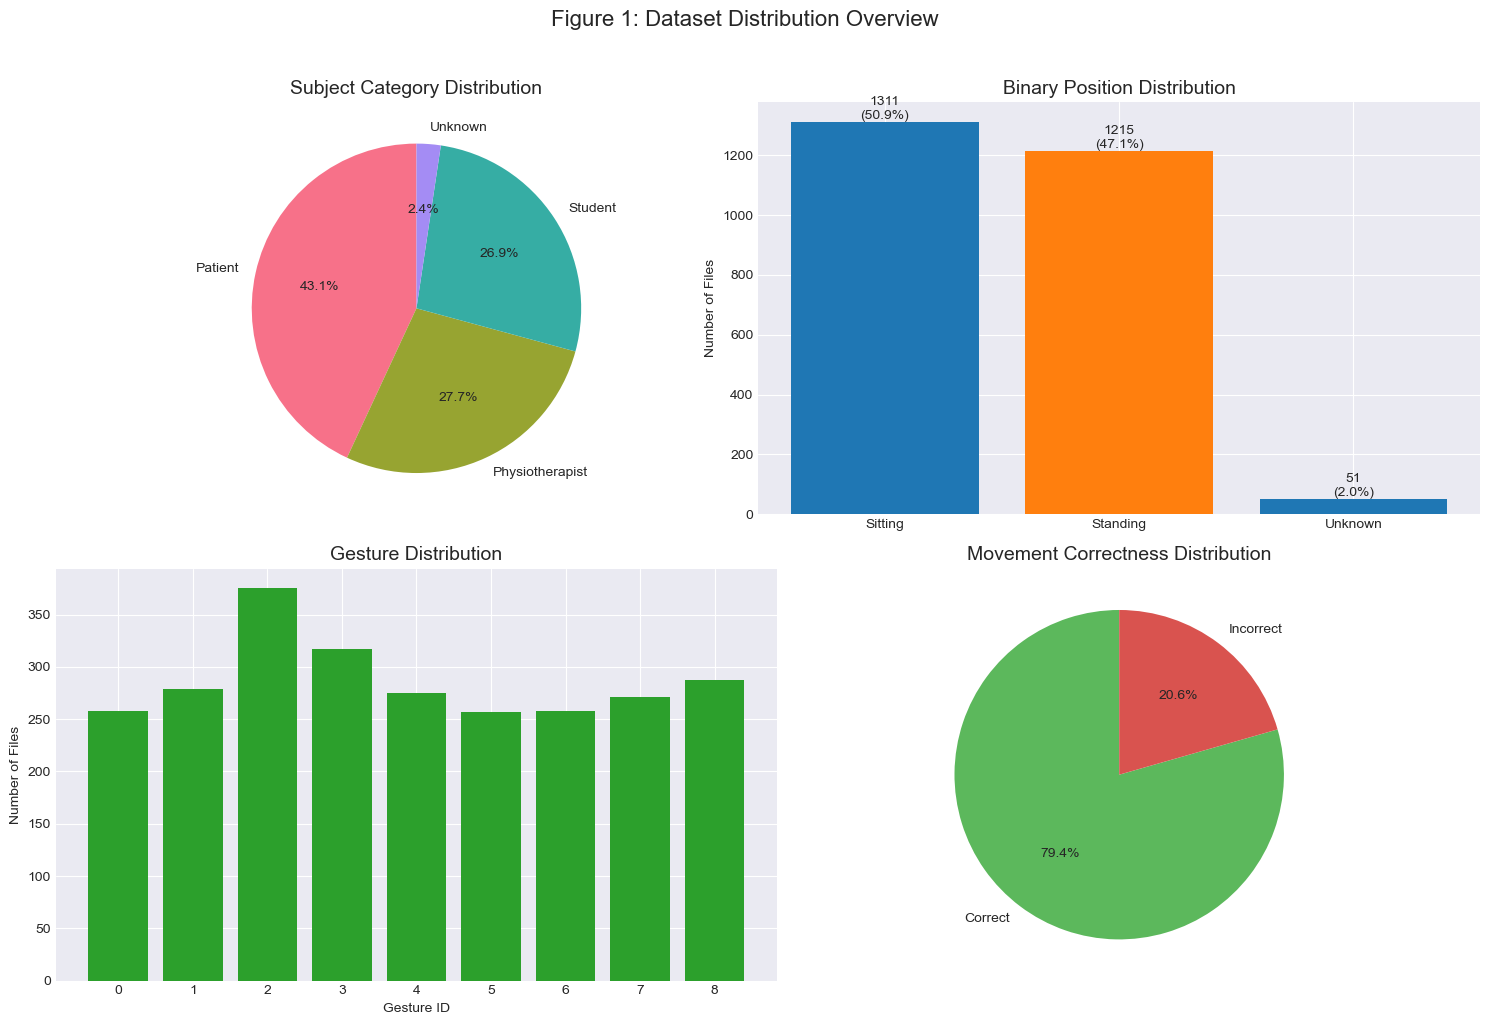

Figure 1 saved to: ../../results/figures/eda/figure_1_dataset_distribution_overview.png


In [ ]:
#  Dataset Distribution Overview
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Figure 1: Dataset Distribution Overview', fontsize=16, y=1.02)

# 1. Subject category distribution
ax1 = axes[0, 0]
subject_counts = df_metadata['subject_category'].value_counts()
colors = sns.color_palette('husl', len(subject_counts))
ax1.pie(subject_counts.values, labels=subject_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax1.set_title('Subject Category Distribution', fontsize=14)

# 2. Binary position distribution
ax2 = axes[0, 1]
binary_pos_counts = df_metadata['position_binary'].value_counts()
bars = ax2.bar(binary_pos_counts.index, binary_pos_counts.values, color=['#1f77b4', '#ff7f0e'])
ax2.set_title('Binary Position Distribution', fontsize=14)
ax2.set_ylabel('Number of Files')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(df_metadata)*100:.1f}%)',
             ha='center', va='bottom')

# 3. Gesture distribution
ax3 = axes[1, 0]
gesture_counts = df_metadata['gesture'].value_counts().sort_index()
bars = ax3.bar(gesture_counts.index, gesture_counts.values, color='#2ca02c')
ax3.set_title('Gesture Distribution', fontsize=14)
ax3.set_xlabel('Gesture ID')
ax3.set_ylabel('Number of Files')
ax3.set_xticks(range(9))

# 4. Correctness distribution
ax4 = axes[1, 1]
correct_counts = df_metadata['correct_label'].value_counts()
labels = ['Correct', 'Incorrect']
values = [correct_counts.get(1, 0), correct_counts.get(2, 0)]
colors = ['#5cb85c', '#d9534f']
ax4.pie(values, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax4.set_title('Movement Correctness Distribution', fontsize=14)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'figure_1_dataset_distribution_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1 saved to:", FIGURES_PATH / 'figure_1_dataset_distribution_overview.png')

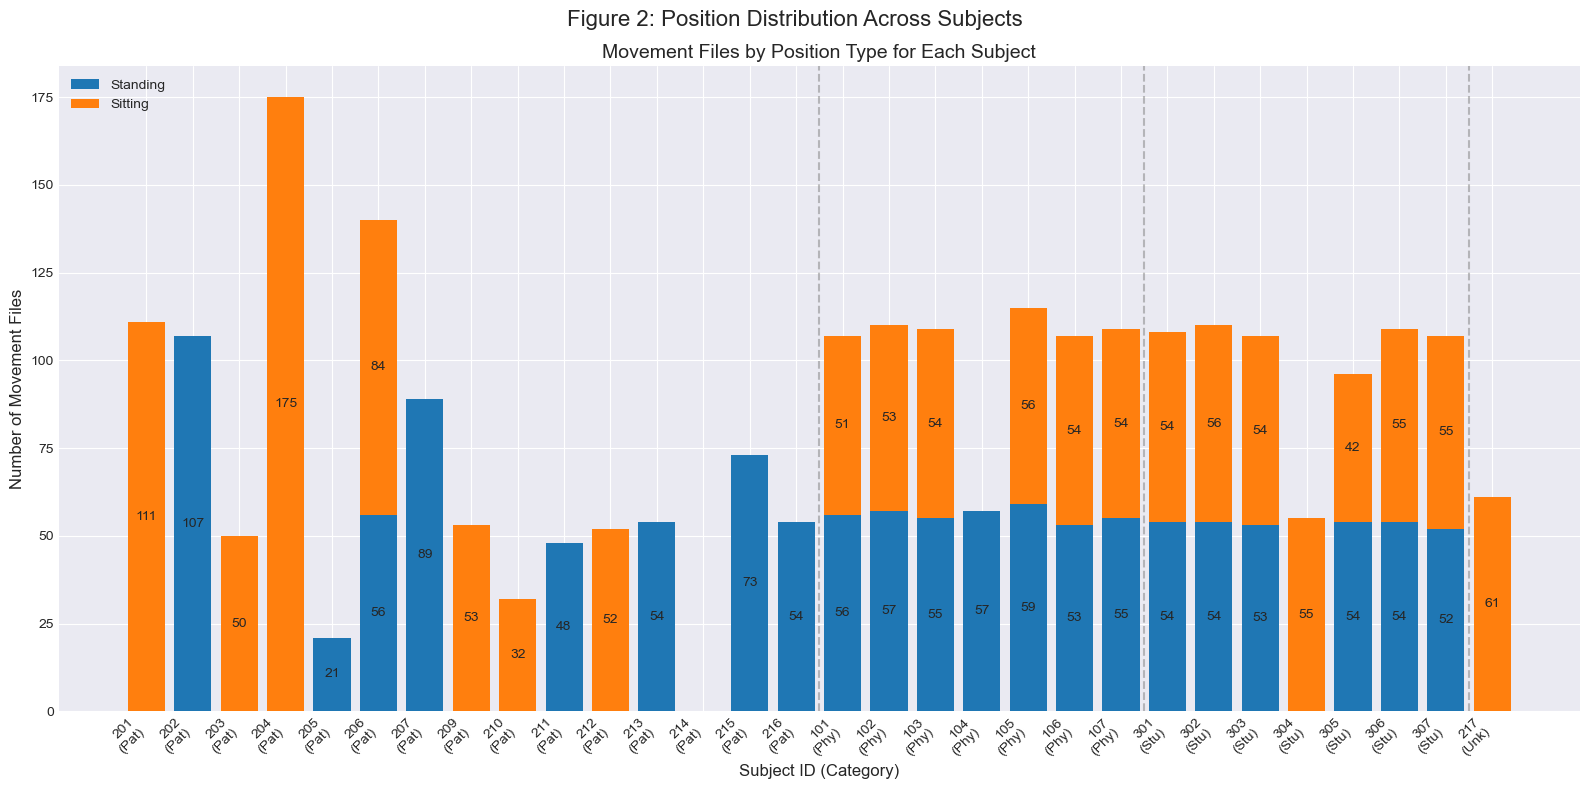

Figure 2 saved to: ../../results/figures/eda/figure_2_position_distribution_subjects.png


In [ ]:
# Position Distribution Across Subjects

position_by_subject = df_metadata.groupby(['subject_id', 'subject_category', 'position_binary']).size().reset_index(name='count')
position_pivot = position_by_subject.pivot_table(
    index=['subject_id', 'subject_category'], 
    columns='position_binary', 
    values='count', 
    fill_value=0
)

# Sort by subject category and ID
position_pivot = position_pivot.sort_index(level=['subject_category', 'subject_id'])

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Figure 2: Position Distribution Across Subjects', fontsize=16)

# Prepare data for stacked bars
subjects = [f"{idx[0]}\n({idx[1][:3]})" for idx in position_pivot.index]
standing_counts = position_pivot.get('Standing', pd.Series(0, index=position_pivot.index))
sitting_counts = position_pivot.get('Sitting', pd.Series(0, index=position_pivot.index))

# bars 
x = np.arange(len(subjects))
width = 0.8
p1 = ax.bar(x, standing_counts, width, label='Standing', color='#1f77b4')
p2 = ax.bar(x, sitting_counts, width, bottom=standing_counts, label='Sitting', color='#ff7f0e')

# Customize plot
ax.set_xlabel('Subject ID (Category)', fontsize=12)
ax.set_ylabel('Number of Movement Files', fontsize=12)
ax.set_title('Movement Files by Position Type for Each Subject', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(subjects, rotation=45, ha='right')
ax.legend()

# value labels on bars
for i, (stand, sit) in enumerate(zip(standing_counts, sitting_counts)):
    if stand > 0:
        ax.text(i, stand/2, str(int(stand)), ha='center', va='center')
    if sit > 0:
        ax.text(i, stand + sit/2, str(int(sit)), ha='center', va='center')

# category separators
category_changes = []
prev_cat = None
for i, (_, cat) in enumerate(position_pivot.index):
    if prev_cat and prev_cat != cat:
        category_changes.append(i - 0.5)
    prev_cat = cat

for change in category_changes:
    ax.axvline(x=change, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'figure_2_position_distribution_subjects.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2 saved to:", FIGURES_PATH / 'figure_2_position_distribution_subjects.png')

In [ ]:
# Generate summary statistics for the paper
print("="*60)
print("IRDS DATASET SUMMARY STATISTICS")
print("="*60)

# Overall statistics
print("\n1. OVERALL DATASET:")
print(f"   - Total movement files: {len(df_metadata)}")
print(f"   - Total subjects: {df_metadata['subject_id'].nunique()}")
print(f"   - Patients: {len(df_metadata[df_metadata['subject_category'] == 'Patient']['subject_id'].unique())}")
print(f"   - Healthy controls: {len(df_metadata[df_metadata['subject_category'].isin(['Physiotherapist', 'Student'])]['subject_id'].unique())}")

# Position statistics
print("\n2. POSITION DISTRIBUTION:")
print("   Original positions:")
for pos in ['stand', 'chair', 'wheelchair', 'sit', 'stand-frame']:
    count = position_counts.get(pos, 0)
    pct = count / len(df_metadata) * 100
    print(f"   - {pos}: {count} ({pct:.1f}%)")

print("\n   Binary classification:")
standing_total = len(df_metadata[df_metadata['position_binary'] == 'Standing'])
sitting_total = len(df_metadata[df_metadata['position_binary'] == 'Sitting'])
print(f"   - Standing: {standing_total} ({standing_total/len(df_metadata)*100:.1f}%)")
print(f"   - Sitting: {sitting_total} ({sitting_total/len(df_metadata)*100:.1f}%)")

# Gesture statistics
print("\n3. GESTURE DISTRIBUTION:")
for gesture_id in sorted(GESTURE_MAPPING.keys()):
    count = gesture_counts.get(gesture_id, 0)
    pct = count / len(df_metadata) * 100
    print(f"   - Gesture {gesture_id}: {count} ({pct:.1f}%)")

# Save metadata for next notebooks
metadata_path = Path("../../data/processed/metadata.csv")
metadata_path.parent.mkdir(parents=True, exist_ok=True)
df_metadata.to_csv(metadata_path, index=False)
print(f"\n✓ Metadata saved to: {metadata_path}")

print("\n" + "="*60)
print("Data exploration completed successfully!")
print("="*60)

IRDS DATASET SUMMARY STATISTICS

1. OVERALL DATASET:
   - Total movement files: 2577
   - Total subjects: 30
   - Patients: 15
   - Healthy controls: 14

2. POSITION DISTRIBUTION:
   Original positions:
   - stand: 1215 (47.1%)
   - chair: 842 (32.7%)
   - wheelchair: 359 (13.9%)
   - sit: 110 (4.3%)
   - stand-frame: 0 (0.0%)

   Binary classification:
   - Standing: 1215 (47.1%)
   - Sitting: 1311 (50.9%)

3. GESTURE DISTRIBUTION:
   - Gesture 0: 258 (10.0%)
   - Gesture 1: 279 (10.8%)
   - Gesture 2: 375 (14.6%)
   - Gesture 3: 317 (12.3%)
   - Gesture 4: 275 (10.7%)
   - Gesture 5: 257 (10.0%)
   - Gesture 6: 258 (10.0%)
   - Gesture 7: 271 (10.5%)
   - Gesture 8: 287 (11.1%)

✓ Metadata saved to: ../../data/processed/metadata.csv

Data exploration completed successfully!
